<a href="https://colab.research.google.com/github/Ian-Sinclair/Computer-Vision-Object-Detection-and-Counting/blob/main/ENCE_4620_1_Homework_3_Ian_Sinclair.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mp
import PIL as pl
import cv2
from statistics import mean
import math
import os

from tensorflow.keras.preprocessing import image

from scipy.spatial import distance as dist

import numpy as np
import argparse
import glob

from google.colab import drive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Raw Images

In [ ]:
raw_images = []

image_path = 'drive/MyDrive/Blood-cells_12.Red-blood-ce.jpg'
raw_images.append( mp.imread(image_path) )

image_path = 'drive/MyDrive/neuron.jpg'
raw_images.append( mp.imread(image_path) )

# Displaying Raw Images

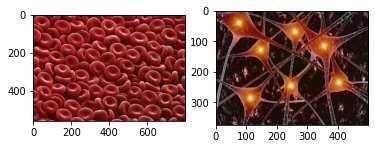

In [ ]:
%matplotlib inline
fig, axs = plt.subplots(1, len( raw_images ))
for i in range( 0 , len( raw_images )) :
  axs[i].imshow( raw_images[i] )

# RGB to grayscale

In [ ]:
from traitlets.traitlets import List
def RGB_to_Greyscale( image ) :
  temp = image.copy()
  grey = np.zeros(( len(temp), len(temp[0]) ), dtype = int )

  for i in range(0 , len( image ) ) :
    for j in range(0 , len( image[i] ) ) :
      Filter =  0.299*temp[i][j][0] + 0.587*temp[i][j][1] + 0.114*temp[i][j][2]
      grey[i][j] = int( Filter )

  return grey

In [ ]:
gray_scale = []

for image in raw_images :
  gray_scale.append( RGB_to_Greyscale( image ) )

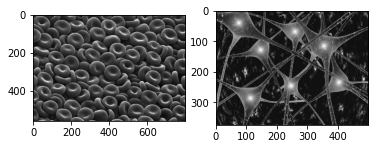

In [ ]:
%matplotlib inline
fig, axs = plt.subplots(1, len( gray_scale ))
for i in range( 0 , len( gray_scale )) :
  axs[i].imshow( gray_scale[i], cmap='gray' )

# Histogram Generation

In [ ]:
def generate_histogram( image ) :
  temp = image.copy()
  hist = []

  #Initialize an emply list on [0,255]
  for i in range( 0 , 256 ) :
    hist += [0]

  #Fill list with histogram values
  for i in range( 0 , len( image ) ) :
    for j in range( 0 , len( image[i] ) ) :
      intensity = int( image[i][j] )
      hist[intensity] += 1

  return hist

In [ ]:
def normalize_histogram( histogram ) :
  temp = histogram.copy()
  r = sum( temp )
  for i in range( 0 , len( temp ) ) :
    temp[i] = temp[i]/r
  
  return temp

In [ ]:
def generate_CDF( histogram ) :
  CDF = np.zeros( [256] )

  CDF[0] = histogram[0]

  for i in range( 1 , len( histogram ) ) :
    CDF[i] = CDF[i-1] + histogram[i]
  
  return CDF

In [ ]:
histograms = []
for imagee in gray_scale :
  histograms.append( normalize_histogram(  generate_histogram( imagee ) )  )

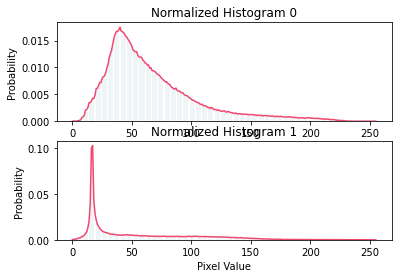

In [ ]:
color_1 = "#ef476f"
color_2 = "#EFF5F7"


%matplotlib inline
fig, axs = plt.subplots( len( histograms ) )
for i in range( 0 , len(histograms) ) :
  axs[i].plot(histograms[i], color=color_1)
  axs[i].bar(np.arange(len(histograms[i])), histograms[i], color=color_2)
  plt.setp(axs[i], xlabel='Pixel Value')
  plt.setp(axs[i], ylabel='Probability')
  axs[i].set_title('Normalized Histogram ' + str(i))



# Binary Image by Thresholding

In [ ]:
def Otsu( histogram ) :

  sig_max = 0
  t_best = 0
  q1 = generate_CDF( histogram )

  #mu = np.zeros(256,dtype = 'int')
  mu = 0
  for p in range( 0 , len( q1 ) ) :
    mu += p * histogram[p]

  mu1 = ((2)*histogram[2])/q1[2]
  mu2 = (q1[2]-mu1)/(1-q1[2])

  for t in range(1 , 255) :
    sig = q1[t]*(1-q1[t])*((mu1-mu2)**2)
    if sig > sig_max :
      t_best = t
      sig_max = sig

    mu1 = ((q1[t]*mu1) + (t+1)*histogram[t+1])/(q1[t+1])

    mu2 = (mu-(q1[t+1]*mu1))/(1-q1[t+1])
      
  
  return t_best



In [ ]:
print(Otsu( histograms[0] ))

88


In [ ]:
def Binary_Conversion( image, t : int) :
  binary = np.zeros(( len(image), len(image[0]) ), dtype = int )

  for i in range( 0 , len( image )) :
    for j in range( 0 , len( image[i] )) :
      if image[i][j] >= t :
        binary[i][j] = 1
      if image[i][j] < t :
        binary[i][j] = 0
  
  return binary


In [ ]:
binary_scale = []
for i in range(0 , len(gray_scale)) :
  binary_scale.append(  Binary_Conversion( gray_scale[i], Otsu( histograms[i]) )  )

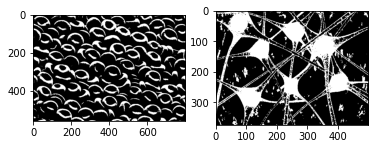

In [ ]:
%matplotlib inline
fig, axs = plt.subplots(1, len( binary_image ))
for i in range(0 , len( binary_scale )) :
  axs[i].imshow( binary_scale[i], cmap='gray' )

# Morphological operators

Dilation

In [ ]:
def Dilation( image ) :
  Dilated_image = image.copy()

  temp_image = cv2.copyMakeBorder(image.copy(), 1, 1, 1, 1, cv2.BORDER_CONSTANT,value=0)

  mask = [(1,0), (-1,0), (0,1), (0,-1), (1,1), (-1,1), (-1,-1), (-1,1)]

  for i in range(0 , len( image ) ) :
    for j in range(0 , len( image[i] ) ) :
      Dilated_image[i][j] = 0
      for k in mask :
          if temp_image[i+k[0]][j+k[1]] == 1 :
            Dilated_image[i][j] = 1
            break

  return Dilated_image


Erosion

In [ ]:
def erosion( image ) :
  eroded_image = image.copy()  

  mask = [(1,0), (-1,0), (0,1), (0,-1), (1,1), (-1,1), (-1,-1), (-1,1)]

  for i in range(0 , len( image ) ) :
    for j in range(0 , len( image[i] ) ) :
      eroded_image[i][j] = 1
      for k in mask :
        if 0 <= i+k[0] < len( image ) and 0 <= j+k[1] < len( image[i] ) :
          if image[i+k[0]][j+k[1]] != 1 :
            eroded_image[i][j] = 0
            break
        else :
          eroded_image[i][j] = 0
          break

  return eroded_image

In [ ]:
neuron_image = erosion( binary_scale[1] )
for i in range( 0 , 10 ) :
  neuron_image = erosion( neuron_image )

neuron_image2 = Dilation( neuron_image )
for i in range( 0 , 5 ) :
  neuron_image2 = Dilation( neuron_image2 )

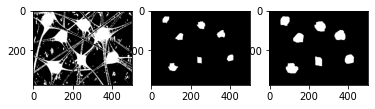

In [ ]:
%matplotlib inline
fig, axs = plt.subplots(1, 3)
axs[0].imshow( binary_scale[1], cmap='gray' )
axs[1].imshow( neuron_image, cmap='gray' )
axs[2].imshow( neuron_image2, cmap='gray' )

In [ ]:
blood_cells_image = erosion( binary_scale[0] )

In [ ]:
blood_cells_image = Dilation( binary_scale[0] )
#for i in range(0 , 3 ) :
#  blood_cells_image = Dilation( blood_cells_image )

blood_cells_image2 = erosion( blood_cells_image )
#for i in range(0 , 2 ) :
#  blood_cells_image2 = erosion( blood_cells_image2 )

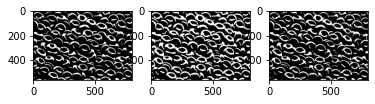

In [ ]:
%matplotlib inline
fig, axs = plt.subplots(1, 3)
axs[0].imshow( binary_scale[0], cmap='gray' )
axs[1].imshow( blood_cells_image, cmap='gray' )
axs[2].imshow( blood_cells_image2, cmap='gray' )

In [ ]:
blood_cells_image = erosion( binary_scale[0] )
for i in range( 0 , 2 ) :
  blood_cells_image = erosion( blood_cells_image )

blood_cells_image2 = Dilation( blood_cells_image )
for i in range( 0 , 2 ) :
  blood_cells_image2 = Dilation( blood_cells_image2 )

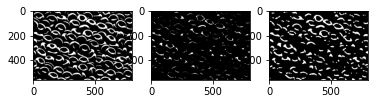

In [ ]:
%matplotlib inline
fig, axs = plt.subplots(1, 3)
axs[0].imshow( binary_scale[0], cmap='gray' )
axs[1].imshow( blood_cells_image, cmap='gray' )
axs[2].imshow( blood_cells_image2, cmap='gray' )

# Labeling

In [ ]:
def negate( image ) :
  label = np.zeros(( len(image), len(image[0]) ), dtype = int )

  for i in range( 0 , len( image )) :
    for j in range( 0 , len( image[i] )) :
      if image[i][j] != 0 :
        label[i][j] = -1
  
  return label

In [ ]:
def neighbors(LB, L, P) :
  N = []
  if L+1 < len( LB ) :
    N += [(L+1, P)]
  if P+1 < len( LB[L] ) :
    N += [(L, P+1)]
  if L-1 >= 0 :
    N += [(L-1, P)]
  if P-1 >= 0 :
    N += [(L, P-1)]
  return N

In [ ]:
def search( LB, label, L, P) :
  LB[L][P] = label
  Nset = neighbors(LB, L, P)

  for m in Nset :
    if LB[m[0],m[1]] == -1 :
      search(LB, label, m[0],m[1])

In [ ]:
def find_components( LB, label ) :
  for L in range( 0 , len( LB )) :
    for P in range( 0 , len( LB[L] )) :
      if LB[L][P] == -1 :
        label += 1
        search( LB, label, L , P)


In [ ]:
def recursive_connected_components( B, LB ) :
  LB = negate( B )
  label = 0
  find_components( LB, label )

  return LB

In [ ]:
import sys
print(sys.getrecursionlimit())

5000


In [ ]:
sys.setrecursionlimit(5000)

In [ ]:
L = recursive_connected_components( neuron_image2, neuron_image2.copy() )

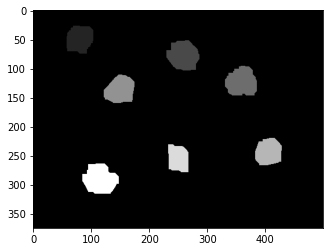

In [ ]:
plt.imshow( L, cmap='gray' )

In [ ]:
print(L.shape)

(375, 500)
